In [2]:
library(edgeR)
library(ggplot2)
library(ggrepel)
library(EnsDb.Hsapiens.v75)
library(stringr)
library(ComplexHeatmap)
#library(clusterProfiler)
library(circlize)
library(ggrepel)
#library(patchwork)
library(org.Hs.eg.db)
library(viridis)
library(ggrastr)
library(tidyr)
library(dplyr)


In [5]:
count_data = read.table("../data/thp1_med_timepoints_raw_counts.tsv", skip = 1, header = TRUE, row.names=1)
count_data = count_data[,6:dim(count_data)[2]]
head(count_data)

,results.star.dmso48_r1_Aligned.sortedByCoord.out.bam,results.star.dmso48_r2_Aligned.sortedByCoord.out.bam,results.star.dmso48_r3_Aligned.sortedByCoord.out.bam,results.star.dmso48_r4_Aligned.sortedByCoord.out.bam,results.star.brq24_r1_Aligned.sortedByCoord.out.bam,results.star.brq24_r2_Aligned.sortedByCoord.out.bam,results.star.brq24_r3_Aligned.sortedByCoord.out.bam,results.star.brq24_r4_Aligned.sortedByCoord.out.bam,results.star.pma24_r1_Aligned.sortedByCoord.out.bam,results.star.pma24_r2_Aligned.sortedByCoord.out.bam,results.star.pma24_r3_Aligned.sortedByCoord.out.bam,results.star.pma24_r4_Aligned.sortedByCoord.out.bam,results.star.brq48_r1_Aligned.sortedByCoord.out.bam,results.star.brq48_r2_Aligned.sortedByCoord.out.bam,results.star.brq48_r3_Aligned.sortedByCoord.out.bam,results.star.brq48_r4_Aligned.sortedByCoord.out.bam,results.star.pma48_r1_Aligned.sortedByCoord.out.bam,results.star.pma48_r2_Aligned.sortedByCoord.out.bam,results.star.pma48_r3_Aligned.sortedByCoord.out.bam,results.star.pma48_r4_Aligned.sortedByCoord.out.bam
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000223972.5,1,0,0,0,2,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
ENSG00000227232.5,1,0,2,0,0,0,0,0,1,0,0,2,0,2,1,1,1,0,0,0
ENSG00000278267.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000243485.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000284332.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ENSG00000237613.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
# change colnames and rownames
colnames(count_data) = gsub("results.star.", "", gsub("_Aligned.sortedByCoord.out.bam", "", colnames(count_data)))

potential_rownames = as.character(sapply(rownames(count_data), function(x) strsplit(x, '[.]')[[1]][1]))
count_data = count_data[!(duplicated(potential_rownames)),]
rownames(count_data) = potential_rownames[!(duplicated(potential_rownames))]                           
annotations_orgDb <- AnnotationDbi::select(EnsDb.Hsapiens.v75, # database
                                     keys = rownames(count_data) ,  # data to use for retrieval
                                     columns = c("SYMBOL"), # information to retreive for given data
                                     keytype = "GENEID") # type of data given in 'keys' argument
annotations_orgDb = annotations_orgDb[!duplicated(annotations_orgDb$SYMBOL),]

count_data = count_data[annotations_orgDb$GENEID,]  # you lose a few genes here but not many
rownames(count_data) = annotations_orgDb$SYMBOL
                                   
head(count_data)

,dmso48_r1,dmso48_r2,dmso48_r3,dmso48_r4,brq24_r1,brq24_r2,brq24_r3,brq24_r4,pma24_r1,pma24_r2,pma24_r3,pma24_r4,brq48_r1,brq48_r2,brq48_r3,brq48_r4,pma48_r1,pma48_r2,pma48_r3,pma48_r4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DDX11L1,1,0,0,0,2,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
WASH7P,1,0,2,0,0,0,0,0,1,0,0,2,0,2,1,1,1,0,0,0
MIR1302-10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
FAM138A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
OR4G4P,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
OR4G11P,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
samples = read.csv("../data/bd262_sample_sheet.csv")
samples = samples[1:20,]
head(samples)

,name,cell_line,drug,time,replicate,filename
,<chr>,<chr>,<chr>,<int>,<int>,<chr>
1,dmso48_r1,thp1,DMSO,48,1,210902Van_D21-276061_NA_sequence.fastq.gz
2,dmso48_r2,thp1,DMSO,48,2,210902Van_D21-276062_NA_sequence.fastq.gz
3,dmso48_r3,thp1,DMSO,48,3,210902Van_D21-276063_NA_sequence.fastq.gz
4,dmso48_r4,thp1,DMSO,48,4,210902Van_D21-276064_NA_sequence.fastq.gz
5,brq24_r1,thp1,BRQ,24,1,210902Van_D21-276065_NA_sequence.fastq.gz
6,brq24_r2,thp1,BRQ,24,2,210902Van_D21-276066_NA_sequence.fastq.gz


In [10]:
d0 <- DGEList(count_data)
d0 <- calcNormFactors(d0)
cutoff <- 5
drop <- which(apply(cpm(d0), 1, max) < cutoff)
d <- d0[-drop,] 
dim(d) # number of genes left

[1] 12101    20

In [11]:
samples_to_drop = c(7)
d = d[, -samples_to_drop]
conds = paste(samples$drug, "_", samples$time, sep='')
conds = conds[-samples_to_drop]

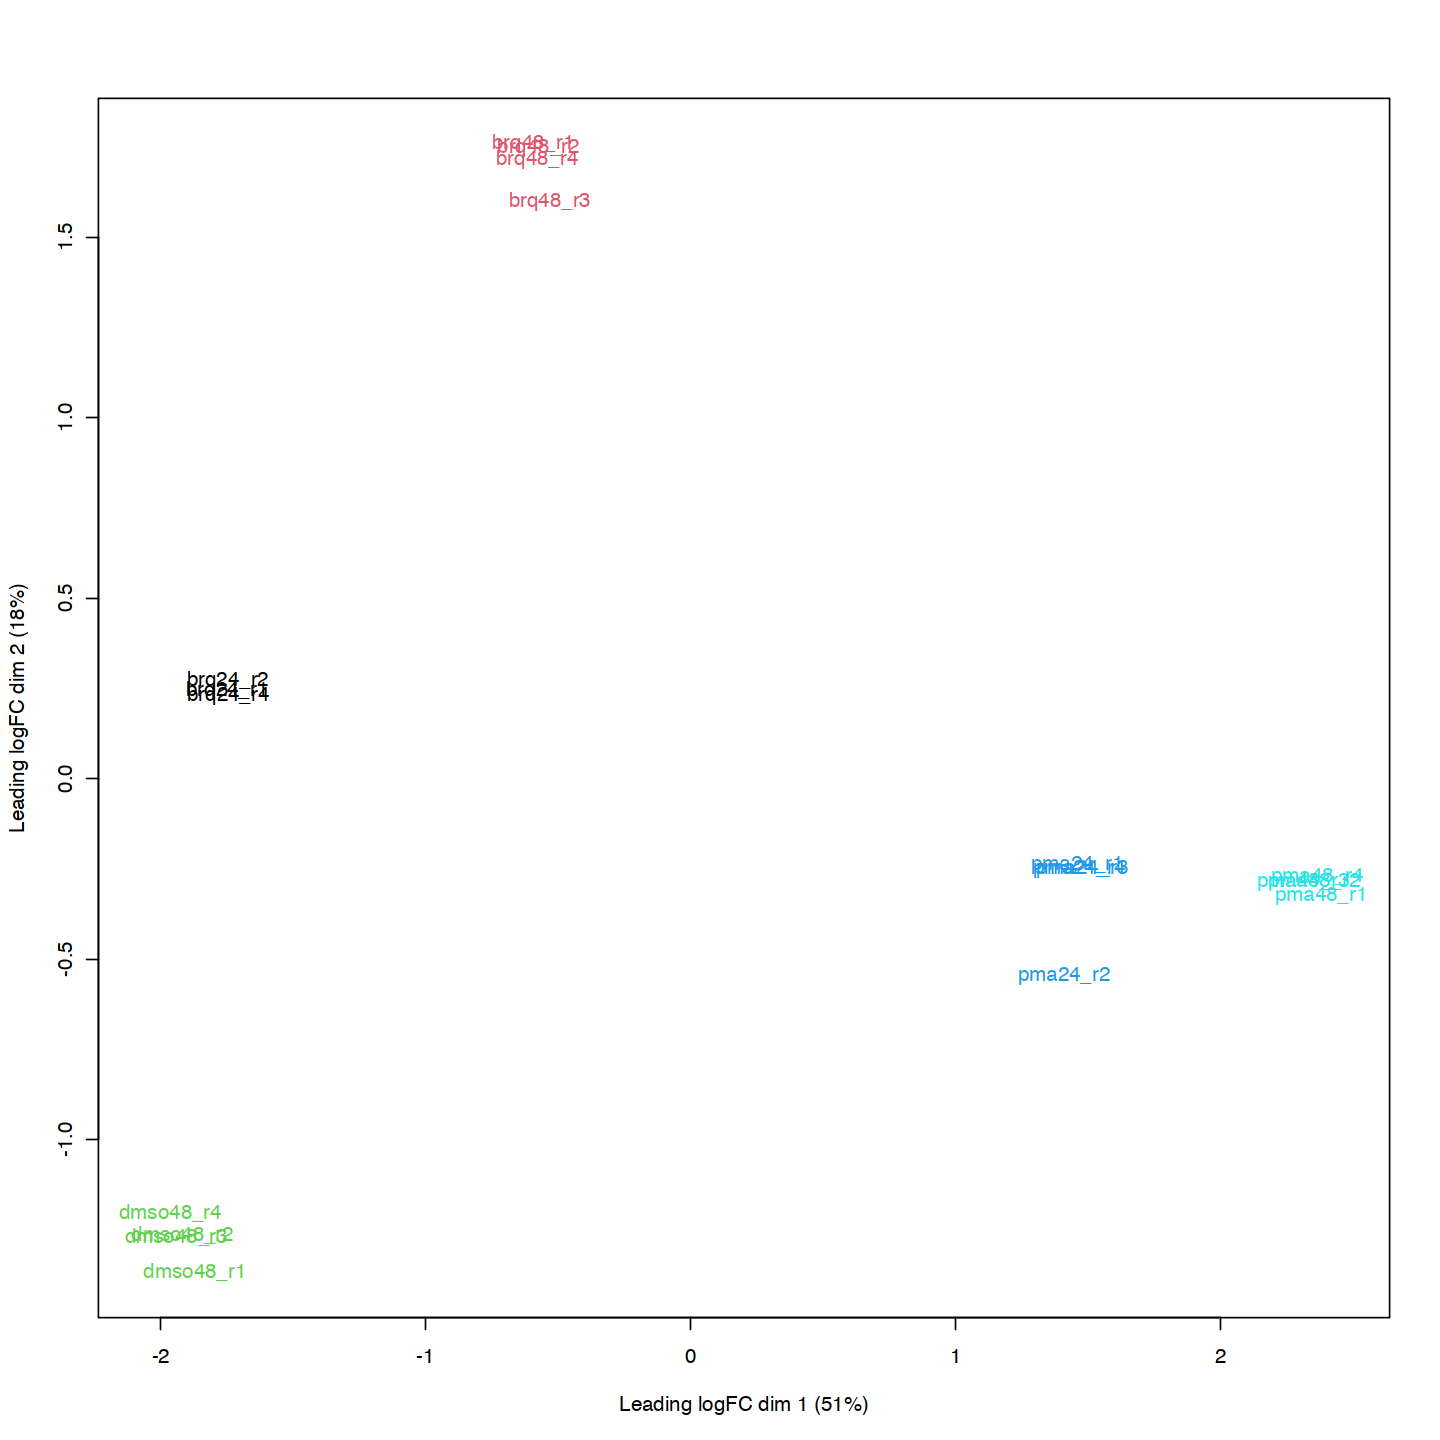

In [12]:
options(repr.plot.width=12, repr.plot.height=12)
plotMDS(d, col = as.numeric(as.factor(conds)))

,condsBRQ_24,condsBRQ_48,condsDMSO_48,condsPMA_24,condsPMA_48
AP006222.2,1.741521,2.940771,1.653990,1.562498,0.4692714
RP5-857K21.4,5.388164,5.771356,4.513161,5.830840,6.0634485
MTND1P23,8.846565,8.518384,8.709623,10.204831,9.4973886
MTND2P28,6.958978,7.234273,6.898843,7.867677,7.4404676
hsa-mir-6723,11.916313,12.057725,10.753259,12.942094,13.1618306
RP5-857K21.7,9.541644,9.571765,8.837475,10.407893,10.6124161


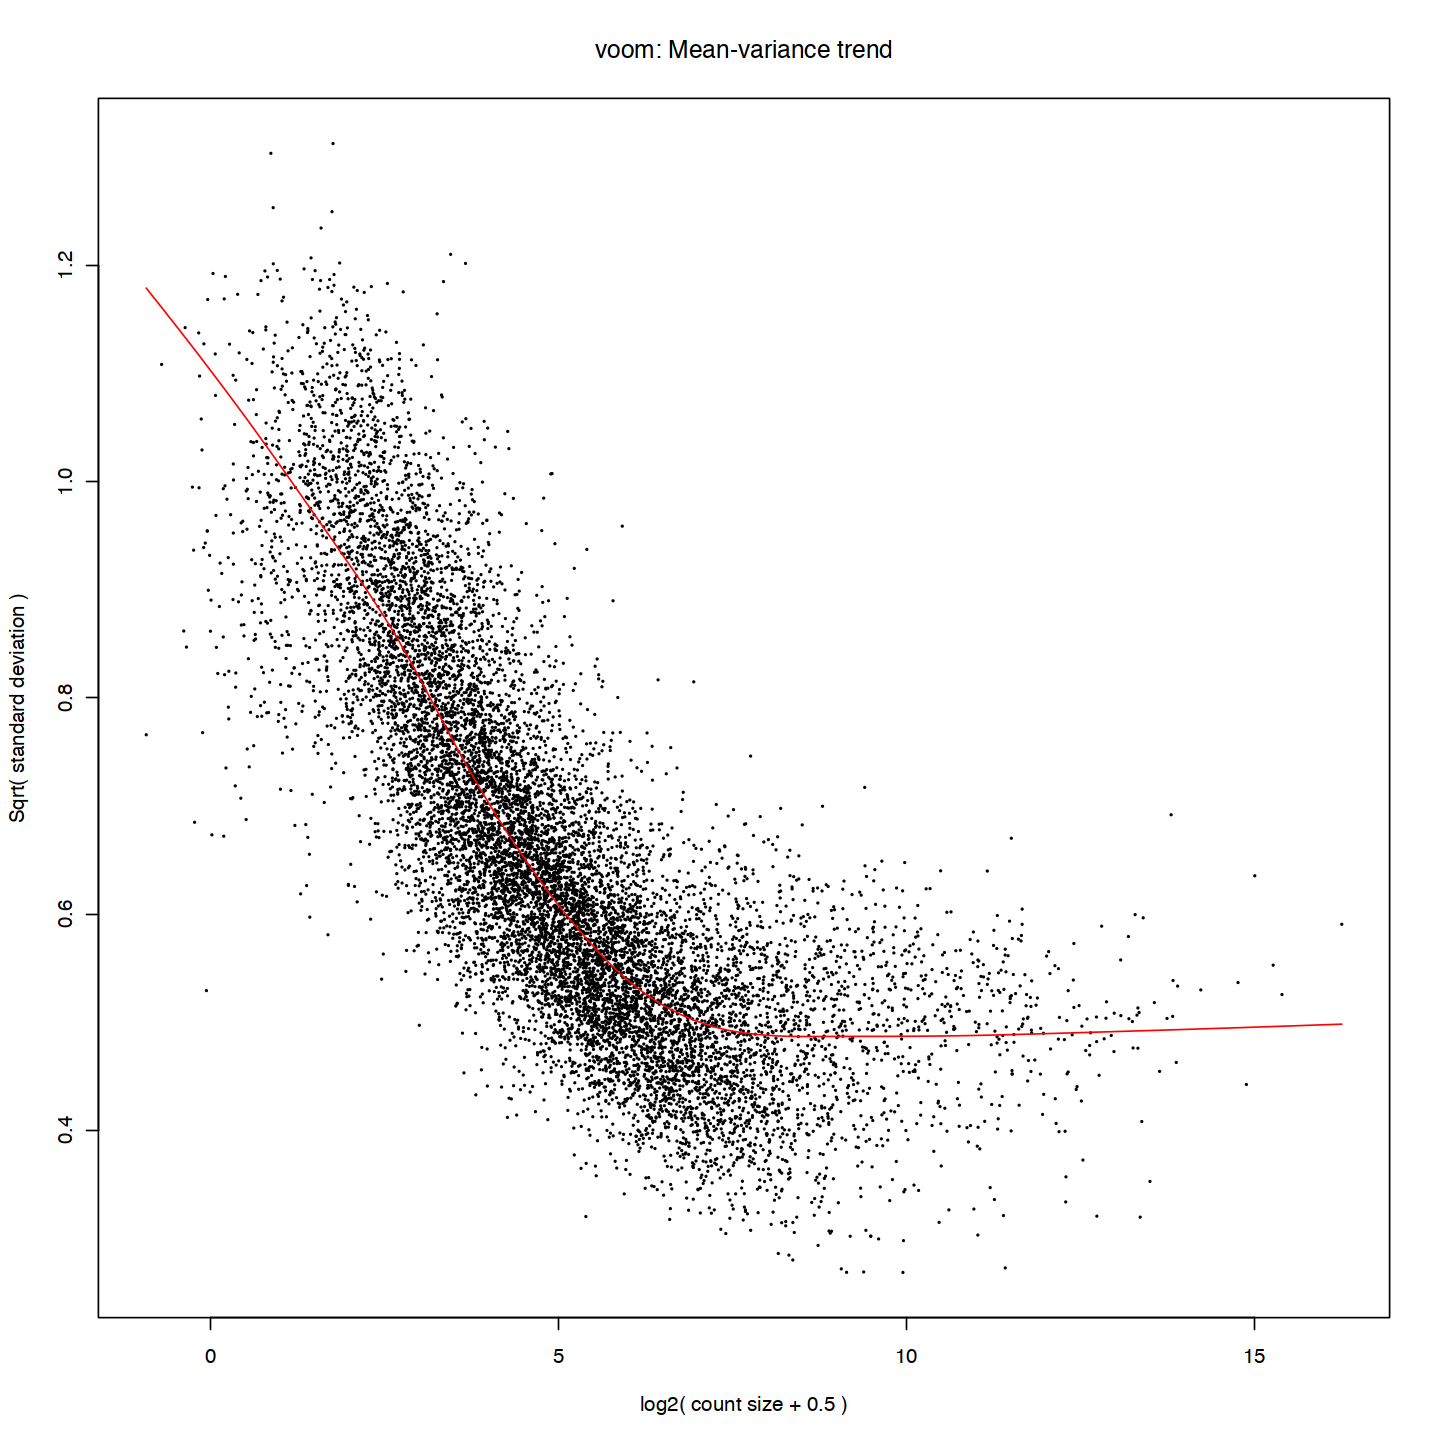

In [13]:
mm <- model.matrix(~0 + conds)
y <- voom(d, mm, plot = T)
fit <- lmFit(y, mm)
head(coef(fit))

In [14]:
norm_data = y$E
#write.csv(norm_data, "211231_BD262_THP1_norm_expr.csv", quote=F)

In [20]:
old_count_data = read.csv("../data/201110_bd153_thp1_logtpm.csv", header = TRUE)
old_count_data = old_count_data[!duplicated(old_count_data$X),]
rownames(old_count_data) = old_count_data$X
old_count_data = old_count_data[,2:23]
colnames(old_count_data)
head(old_count_data)

[1] "THP1_HU_2d"     "THP1_HU_2d.1"   "THP1_HU_2d.2"   "THP1_HU_2d.3"  
 [5] "THP1_HU_4d"     "THP1_HU_4d.1"   "THP1_HU_4d.2"   "THP1_BRQ_2d"   
 [9] "THP1_BRQ_2d.1"  "THP1_BRQ_2d.2"  "THP1_BRQ_2d.3"  "THP1_BRQ_4d"   
[13] "THP1_BRQ_4d.1"  "THP1_BRQ_4d.2"  "THP1_DMSO_2d"   "THP1_DMSO_2d.1"
[17] "THP1_DMSO_2d.2" "THP1_DMSO_2d.3" "THP1_DMSO_4d"   "THP1_DMSO_4d.1"
[21] "THP1_DMSO_4d.2" "THP1_DMSO_4d.3"

,THP1_HU_2d,THP1_HU_2d.1,THP1_HU_2d.2,THP1_HU_2d.3,THP1_HU_4d,THP1_HU_4d.1,THP1_HU_4d.2,THP1_BRQ_2d,THP1_BRQ_2d.1,THP1_BRQ_2d.2,⋯,THP1_BRQ_4d.1,THP1_BRQ_4d.2,THP1_DMSO_2d,THP1_DMSO_2d.1,THP1_DMSO_2d.2,THP1_DMSO_2d.3,THP1_DMSO_4d,THP1_DMSO_4d.1,THP1_DMSO_4d.2,THP1_DMSO_4d.3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DPM1,6.2389700,5.8895330,6.113360,6.187968,6.0946985,5.636840,6.162613,5.404721,5.9061954,5.9135730,⋯,5.874368,5.959177,5.947545,6.352069,6.0794422,6.443024,6.473577,6.382255,6.559100,6.583170
SCYL3,1.4613386,1.4678714,1.495445,2.457892,2.3107148,2.751928,1.540563,2.129791,0.0000000,1.8093024,⋯,1.106517,2.137766,2.503443,1.944051,0.9450979,2.308665,2.445983,1.090168,1.736544,2.147120
C1orf112,0.9082893,0.9130846,1.495445,0.000000,0.0000000,0.967927,1.540563,1.426679,0.8816209,1.8093024,⋯,1.106517,1.708055,1.520119,1.535338,2.7119171,0.000000,0.000000,2.463611,0.000000,1.099728
FGR,2.4287035,2.1802336,3.335934,2.457892,1.5756242,2.751928,2.529247,3.103870,2.1275596,3.0898681,⋯,3.647604,2.963770,0.951643,0.000000,0.9450979,0.000000,1.078775,2.133224,0.000000,1.716457
FUCA2,5.1373367,4.5825409,4.192617,4.895422,5.1562863,5.396064,4.520701,4.932852,4.6685096,4.3949134,⋯,4.443509,4.494313,4.660263,4.785545,3.9823194,4.627926,4.606269,4.488694,4.114910,4.352859
GCLC,1.4613386,2.4370510,2.881330,2.457892,0.9930019,3.112404,1.949954,2.384237,2.5980472,0.8757087,⋯,2.156964,2.137766,2.723437,1.944051,2.7119171,1.573919,2.713961,2.133224,2.772075,2.747540


In [21]:
genes = c("MAFB", "PLIN2", "AIM2", "CD163", "CD86", "TYROBP", "SLC15A3", "IL7R",
    "ITGAM", "LYZ", "CYBB", "CXCR2", "CSF3R", "LYN", "S100A8",
"IRF8", "GFI1", "FLT3", "NPM1", "MYB", "CEBPD", "KLF4", "ZFP36L2")
conds_plot = c(rep("DMSO", 4), rep("BRQ 24h", 3), rep("BRQ 48h", 4), rep("BRQ 96h", 3),
rep("HU 48h", 4), rep("HU 96h", 3), rep("PMA 24h", 4), rep("PMA 48h", 4))

df1 = as.data.frame(norm_data[genes,] - apply(norm_data[genes,1:4], 1, mean))
df2 = as.data.frame(old_count_data[genes,] - apply(old_count_data[genes,19:22], 1, mean))
df = cbind(df1[,c(1:7, 12:15)], df2[,c(12:14, 1:7)], df1[,c(8:11, 16:19)])
colnames(df) = conds_plot

require(reshape2)
df_melt = melt(as.matrix(df))
df_melt = df_melt %>% group_by(Var1, Var2) %>% summarize(lfc_mean = mean(value))
df_recast = dcast(df_melt, Var1 ~ Var2, value.var = "lfc_mean")
rownames(df_recast) = df_recast$Var1
df_recast = df_recast[,3:9]
head(df_recast)

Loading required package: reshape2


Attaching package: 'reshape2'


The following object is masked from 'package:tidyr':

    smiths


`summarise()` has grouped output by 'Var1'. You can override using the `.groups` argument.


,BRQ 24h,BRQ 48h,BRQ 96h,HU 48h,HU 96h,PMA 24h,PMA 48h
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MAFB,3.0906295,5.604064,6.093722,4.9778882,4.2708409,4.864253,3.856827
PLIN2,3.1919528,5.043845,5.074467,2.0770917,2.5284062,4.418663,4.634813
AIM2,2.9894179,4.565484,2.016952,1.6960323,0.8361635,7.035120,8.590099
CD163,2.1808926,6.063902,5.182511,0.7889705,1.5560386,1.972019,1.057697
CD86,0.7782137,5.104791,5.158315,3.9062983,3.9557252,-0.485370,1.134116
TYROBP,1.5620207,3.732724,3.705993,1.6344909,1.7347031,4.297349,4.473315


pdf 
  2

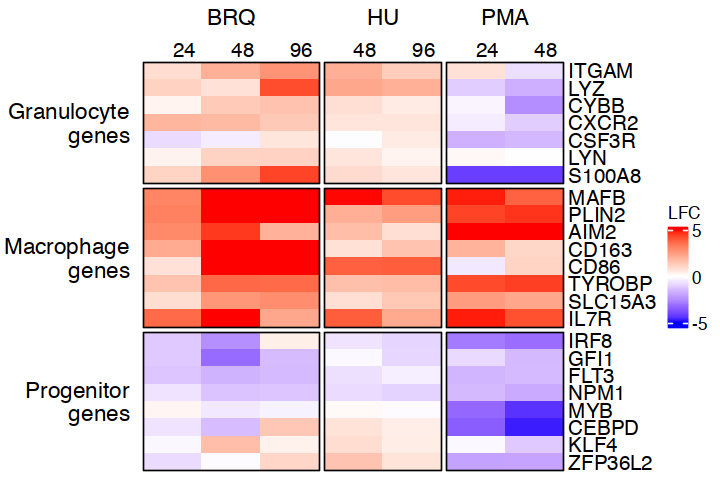

In [22]:
options(repr.plot.width=6, repr.plot.height=4)
col_fun = colorRamp2(c(-5, 0, 5), c("blue", "white", "red"))
colnames(df_recast) = c("24", "48", "96", "48", "96", "24", "48")
h = Heatmap(as.matrix(df_recast), cluster_rows=F, cluster_columns=F,
column_split = factor(c(rep("BRQ", 3), rep("HU", 2), rep("PMA", 2)), levels=c("BRQ", "HU", "PMA")),
row_split = c(rep("Macrophage\ngenes", 8), rep("Granulocyte\ngenes", 7), rep("Progenitor\ngenes", 8)),
column_title_rot = 0, column_names_rot = 0, column_names_side = "top", col=col_fun, border=T,
row_title_rot = 0,
show_column_names = T, name = "LFC")
draw(h)

pdf("220426_thp1_selected_genes_rnaseq.pdf", width=5, height=5)
draw(h)
dev.off()


In [15]:
genes = intersect(row.names(norm_data), row.names(old_count_data))
df1 = norm_data[genes,]
df2 = old_count_data[genes,]
df = cbind(df1[,c(1:7, 12:15)], df2[,c(12:14, 1:7)], df1[,c(8:11, 16:19)])
write.table(df, "../data/220226_thp1_bd153_bd262_combined_rnaseq.txt", sep='\t', quote=F)